# Causal Inference 

## load dataset

In [1]:
!ls

2011.csv  2014.csv		  sample_data
2012.csv  fips.csv		  U.S._Chronic_Disease_Indicators__Asthma.csv
2013.csv  pm25_by_year_state.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import statistics

loading asthma dataset

In [3]:
asthma_dataset = pd.read_csv('/content/U.S._Chronic_Disease_Indicators__Asthma.csv')

loading pm2.5 dataset

In [4]:
pm25 = pd.read_csv('pm25_by_year_state.csv')

<Axes: >

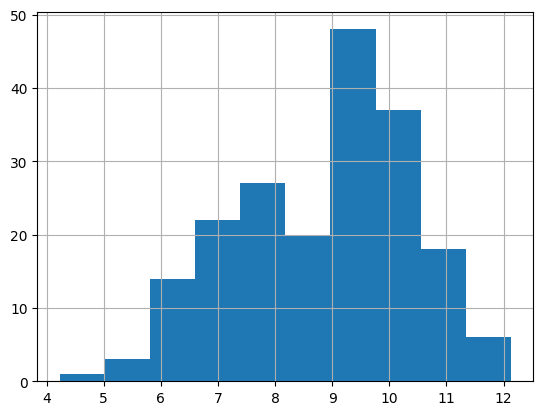

In [5]:
pm25['ds_pm_pred'].hist(bins=10)

loading FIP codes

In [6]:
fips = pd.read_csv('fips.csv')
fips['stusps'] = fips[' stusps'].str.strip()
fips['st'] = fips[' st']

## Data Cleaning and EDA

### data cleaning pm25

In [7]:
pm25_with_states = pd.merge(pm25, fips, how='inner', left_on='statefips', right_on='st')

### data cleaning + EDA asthma

In [8]:
asthma_year = asthma_dataset[(asthma_dataset['YearStart'] >= 2011) & (asthma_dataset['YearStart'] <= 2014)]
hospitalization = asthma_year[asthma_year['Question'] == 'Hospitalizations for asthma']
prevalence = asthma_year[asthma_year['Question'] == 'Current asthma prevalence among adults aged >= 18 years']
mortality = asthma_year[asthma_year['Question'] == 'Asthma mortality rate']

In [9]:
def asthma_cleaning_pipeline(data_of_interest, pm25_with_states, interest_name, data_value_type):
  overall_adjusted_rate = data_of_interest[(data_of_interest['StratificationCategory1'] == 'Overall') & (data_of_interest['DataValueType'] == data_value_type)]
  overall_adjusted_rate_clean = overall_adjusted_rate[['YearStart', 'LocationAbbr', 'DataValueType', 'DataValue']]
  overall_adjusted_rate_clean = overall_adjusted_rate_clean[overall_adjusted_rate_clean['DataValue'].notna()]
  interest_pm25 = pd.merge(overall_adjusted_rate_clean, pm25_with_states, how='inner', left_on=['YearStart', 'LocationAbbr'], right_on=['year', 'stusps'])
  interest_pm25 = interest_pm25.rename(columns={'ds_pm_pred': 'mean daily pm2.5 concentration', 'DataValue': interest_name})
  return interest_pm25

#### Continuous variable

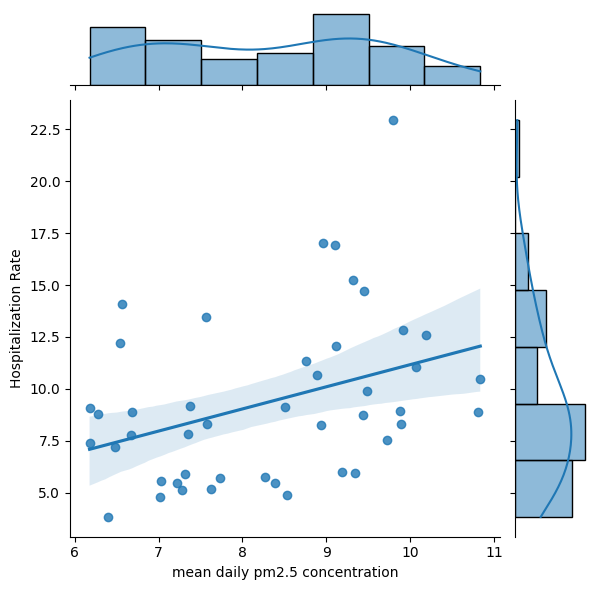

In [10]:
hospitalization_pm25 = asthma_cleaning_pipeline(hospitalization, pm25_with_states, 'Hospitalization Rate', 'Age-adjusted Rate')
sns.jointplot(hospitalization_pm25, x='mean daily pm2.5 concentration', y='Hospitalization Rate', kind="reg")

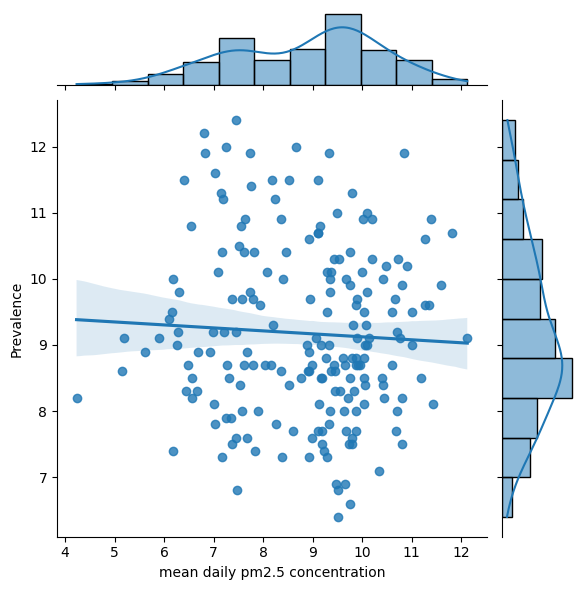

In [11]:
prevalence_pm25 = asthma_cleaning_pipeline(prevalence, pm25_with_states, 'Prevalence', 'Age-adjusted Prevalence')
sns.jointplot(prevalence_pm25, x='mean daily pm2.5 concentration', y='Prevalence', kind="reg")

In [12]:
cor = stats.pearsonr(prevalence_pm25['mean daily pm2.5 concentration'], prevalence_pm25['Prevalence'])
cor

PearsonRResult(statistic=-0.05225704298952346, pvalue=0.4669710022847507)

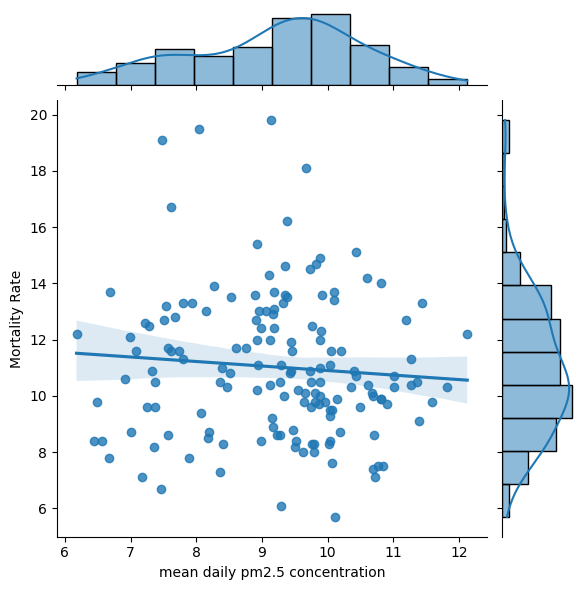

In [13]:
mortality_pm25 = asthma_cleaning_pipeline(mortality, pm25_with_states, 'Mortality Rate', 'Age-adjusted Rate', )
sns.jointplot(mortality_pm25, x='mean daily pm2.5 concentration', y='Mortality Rate', kind="reg")

#### Categorical variable

In [14]:
def asthma_gender_pipeline(data_of_interest, interest_name, data_value_type):
  gender_rate = data_of_interest[(data_of_interest['StratificationCategory1'] == 'Gender') & (data_of_interest['DataValueType'] == data_value_type)]
  gender_rate_clean = gender_rate[gender_rate['DataValue'].notna()].rename(columns={'Stratification1': 'Gender', 'DataValue': interest_name})
  plt.figure(figsize=(8,5))
  sns.stripplot(data=gender_rate_clean, x=interest_name, hue="Gender", dodge=True)
  plt.title(f'{interest_name} by Gender Across All States')
  plt.show()

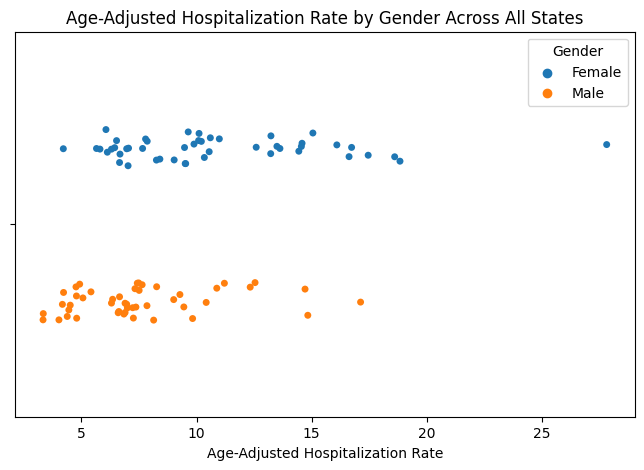

In [15]:
asthma_gender_pipeline(hospitalization, 'Age-Adjusted Hospitalization Rate', 'Age-adjusted Rate')

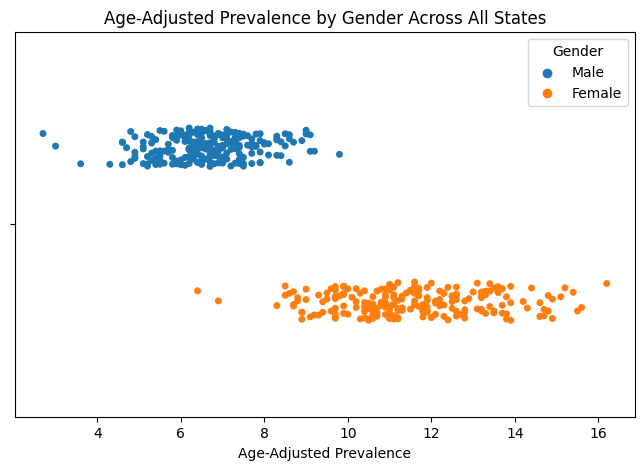

In [16]:
asthma_gender_pipeline(prevalence, 'Age-Adjusted Prevalence', 'Age-adjusted Prevalence')

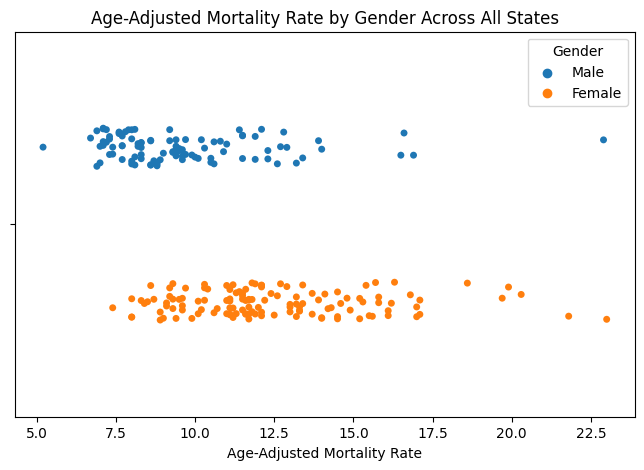

In [17]:
asthma_gender_pipeline(mortality, 'Age-Adjusted Mortality Rate', 'Age-adjusted Rate')

In [18]:
prevalence['DataValueUnit'].unique()

array(['%'], dtype=object)

In [19]:
def asthma_race_pipeline(data_of_interest, interest_name, data_value_type):
  gender_rate = data_of_interest[(data_of_interest['StratificationCategory1'] == 'Race/Ethnicity') & (data_of_interest['DataValueType'] == data_value_type)]
  gender_rate_clean = gender_rate[gender_rate['DataValue'].notna()].rename(columns={'Stratification1': 'Race/Ethnicity', 'DataValue': interest_name})
  plt.figure(figsize=(8,5))
  sns.stripplot(data=gender_rate_clean, x=interest_name, hue="Race/Ethnicity", dodge=True)
  plt.title(f'{interest_name} by Race/Ethnicity Across All States')
  plt.show()

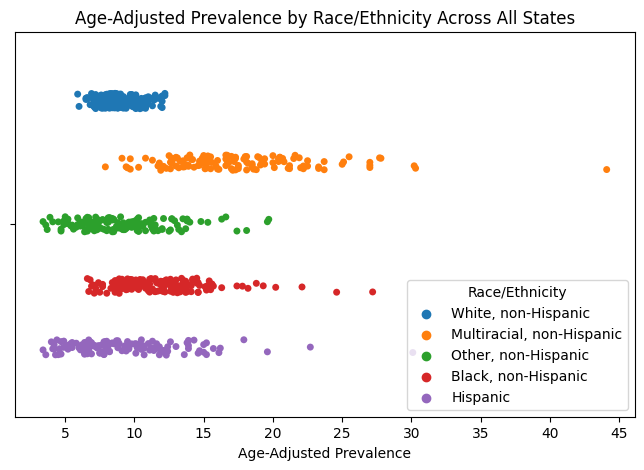

In [20]:
asthma_race_pipeline(prevalence, 'Age-Adjusted Prevalence', 'Age-adjusted Prevalence')

### census data cleaning

In [21]:
def clean(df):
  clean_dataset = df[["state","house_heat_coal_PE", "house_heat_wood_PE", "commute_walked_PE", "commute_worked_home_PE", "industry_construct_PE", "industry_manufacture_PE",
                                     "industry_transport_PE", "female_PE", "white_PE", "proverty_people_P"]]
  return clean_dataset

In [22]:
import functools
year_dfs = []
for year in range(2011, 2015):
  dataset_year = pd.read_csv(f'/content/{year}.csv')
  clean_dataset = clean(dataset_year)
  clean_dataset['year'] = year
  year_dfs.append(clean_dataset)

confounders = functools.reduce(lambda x, y: pd.concat([x, y]), year_dfs)

<ipython-input-22-431d46396acb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['year'] = year
<ipython-input-22-431d46396acb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['year'] = year
<ipython-input-22-431d46396acb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [23]:
confounders

,state,house_heat_coal_PE,house_heat_wood_PE,commute_walked_PE,commute_worked_home_PE,industry_construct_PE,industry_manufacture_PE,industry_transport_PE,female_PE,white_PE,proverty_people_P,year
0,Alabama,0.0,1.1,1.1,2.6,6.4,13.5,5.0,51.6,69.1,19.0,2011
1,Alaska,0.3,5.5,7.6,4.8,7.8,3.3,6.9,48.4,66.8,10.5,2011
2,Arizona,0.0,2.1,2.2,5.5,6.5,7.5,5.0,50.2,79.3,19.0,2011
3,Arkansas,0.0,4.4,1.9,3.3,6.1,13.4,5.8,50.7,78.2,19.5,2011
4,California,0.0,1.8,2.8,5.3,5.8,9.9,4.6,50.3,62.9,16.6,2011
...,...,...,...,...,...,...,...,...,...,...,...,...
47,Washington,0.0,4.4,3.5,5.5,6.1,10.5,5.2,50.0,77.7,13.2,2014
48,West Virginia,0.5,6.3,2.9,2.5,5.7,7.7,5.6,50.6,93.6,18.3,2014
49,Wisconsin,0.0,4.4,3.2,4.1,5.2,18.8,4.4,50.4,86.3,13.2,2014
50,Wyoming,0.6,5.4,3.6,4.8,8.0,4.0,6.3,49.1,91.0,11.2,2014


In [24]:
outcome_treatment = asthma_cleaning_pipeline(prevalence, pm25_with_states, 'Prevalence', 'Age-adjusted Prevalence')

In [25]:
xyz = pd.merge(outcome_treatment, confounders, left_on=['year', 'stname'], right_on=['year', 'state'])

In [26]:
xyz

,YearStart,LocationAbbr,DataValueType,Prevalence,year,statefips,mean daily pm2.5 concentration,ds_pm_stdd,stname,st,...,house_heat_coal_PE,house_heat_wood_PE,commute_walked_PE,commute_worked_home_PE,industry_construct_PE,industry_manufacture_PE,industry_transport_PE,female_PE,white_PE,proverty_people_P
0,2013,AL,Age-adjusted Prevalence,8.5,2013,1,10.039805,4.201070,Alabama,1,...,0.0,1.1,1.0,2.5,6.4,14.4,4.9,51.6,68.9,18.7
1,2011,AL,Age-adjusted Prevalence,8.0,2011,1,10.696324,3.159462,Alabama,1,...,0.0,1.1,1.1,2.6,6.4,13.5,5.0,51.6,69.1,19.0
2,2012,AL,Age-adjusted Prevalence,8.5,2012,1,10.396601,4.228621,Alabama,1,...,0.0,1.2,1.2,2.6,6.7,13.3,5.6,51.5,69.1,19.0
3,2014,AL,Age-adjusted Prevalence,9.5,2014,1,11.007064,5.885860,Alabama,1,...,0.0,1.0,1.1,2.9,6.4,14.0,4.8,51.6,68.5,19.3
4,2011,AR,Age-adjusted Prevalence,9.5,2011,5,10.597298,3.221463,Arkansas,5,...,0.0,4.4,1.9,3.3,6.1,13.4,5.8,50.7,78.2,19.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2011,WV,Age-adjusted Prevalence,9.1,2011,54,10.136150,3.164028,West Virginia,54,...,0.7,6.2,2.7,3.0,6.4,8.5,5.5,50.7,93.9,18.6
192,2012,WY,Age-adjusted Prevalence,9.0,2012,56,6.258089,2.730487,Wyoming,56,...,0.4,5.3,3.2,5.5,8.2,3.4,7.2,49.2,90.9,12.6
193,2014,WY,Age-adjusted Prevalence,8.2,2014,56,4.231558,2.076433,Wyoming,56,...,0.6,5.4,3.6,4.8,8.0,4.0,6.3,49.1,91.0,11.2
194,2013,WY,Age-adjusted Prevalence,9.1,2013,56,5.198567,2.414342,Wyoming,56,...,0.9,5.2,4.6,3.7,6.5,3.7,6.2,48.9,90.7,10.9


Text(0.5, 1.0, 'Distribution of mean daily pm2.5 concentration')

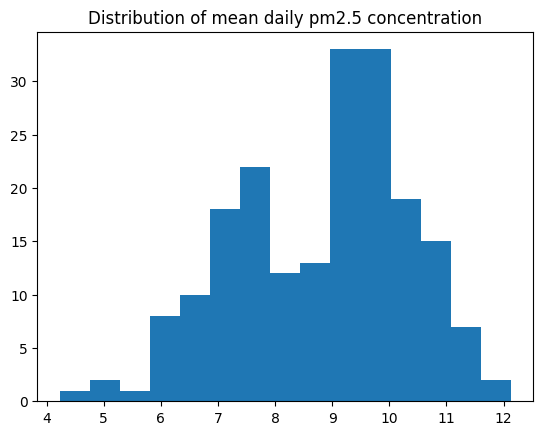

In [27]:
plt.hist(xyz['mean daily pm2.5 concentration'], bins=15)
plt.title('Distribution of mean daily pm2.5 concentration')

In [28]:
np.mean(xyz['mean daily pm2.5 concentration'] > 10)

0.22448979591836735

In [29]:
xyz['treatment'] = xyz['mean daily pm2.5 concentration'] > 10

## Propensity Score with Logistic Regression

In [30]:
Z = xyz['treatment'].astype(int)

In [31]:
X = xyz[['house_heat_coal_PE', \
       'house_heat_wood_PE', 'commute_walked_PE', 'commute_worked_home_PE', \
       'industry_construct_PE', 'industry_manufacture_PE', \
       'industry_transport_PE', 'female_PE', 'white_PE', 'proverty_people_P']]

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve

In [33]:
clf = LogisticRegression(random_state=0).fit(X, Z)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Assessing if the propensity score model is well-calibrated

In [34]:
prob_true, prob_pred = calibration_curve(Z, clf.predict_proba(X)[:, 1])

Text(0.5, 1.0, 'Calibration Curve for Logistis Regression of Z ~ X')

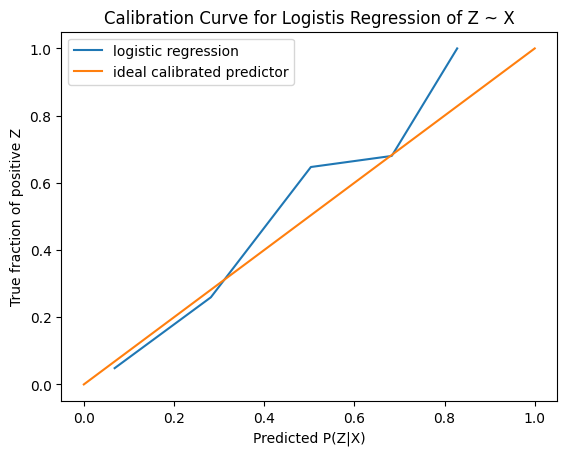

In [35]:
plt.plot(prob_pred, prob_true, label='logistic regression')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label='ideal calibrated predictor')
plt.xlabel('Predicted P(Z|X)')
plt.ylabel('True fraction of positive Z')
plt.legend()
plt.title('Calibration Curve for Logistis Regression of Z ~ X')

Text(0.5, 1.0, 'Distribution of propensity scores')

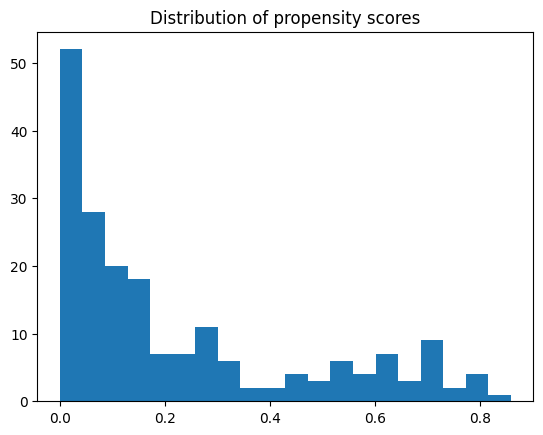

In [36]:
plt.hist(clf.predict_proba(X)[:, 1], bins=20)
plt.title('Distribution of propensity scores')

Text(0.5, 1.0, 'Cumulative Distribution of propensity scores')

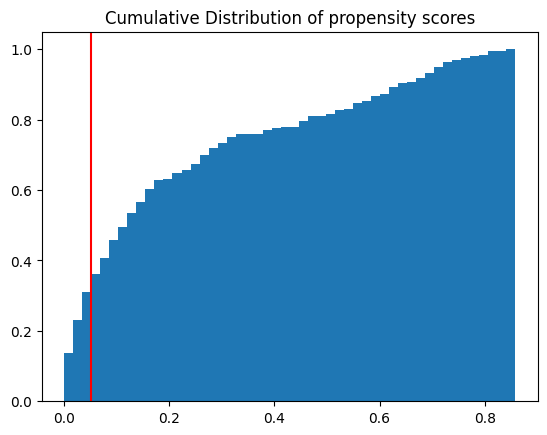

In [37]:
plt.hist(clf.predict_proba(X)[:, 1], cumulative=True, bins=50, density=True)
plt.axvline(x=0.05, c='red')
plt.title('Cumulative Distribution of propensity scores')

In [38]:
xyz['propensity'] = clf.predict_proba(X)[:, 1]

In [39]:
np.mean((xyz['propensity'] > 0.05) & (xyz['propensity'] < 0.95))

0.6938775510204082

In [40]:
obs_prop_trimmed = xyz[(xyz['propensity'] >= 0.05) & (xyz['propensity'] <= 0.95)]
n = len(obs_prop_trimmed)
trimmed_ipw_estimate = 1/n * (np.sum(obs_prop_trimmed[obs_prop_trimmed['treatment'] == 1]['mean daily pm2.5 concentration'] / obs_prop_trimmed[obs_prop_trimmed['treatment'] == 1]['propensity']) - np.sum(obs_prop_trimmed[obs_prop_trimmed['treatment'] == 0]['mean daily pm2.5 concentration'] / (1 - obs_prop_trimmed[obs_prop_trimmed['treatment'] == 0]['propensity'])))
trimmed_ipw_estimate

0.8187003819358585

### Uncertainty Quantification with Bootstrap for Trimmed IPW

In [41]:
def draw_tau_hat(data, lower, upper, random_state=None):
    """Returns a single bootstrapped estimate of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        random_state: integer to help standardize sampling output 
        for grading and troubleshooting purposes
    Output:
        float, estimated average treatment effect
    """
    new_data = data.sample(n = len(data), replace=True, random_state=random_state)
    obs_prop_trimmed = new_data[(new_data['propensity'] >= lower) & (new_data['propensity'] <= upper)]
    trimmed_ipw_estimate = 1/n * (np.sum(obs_prop_trimmed[obs_prop_trimmed['treatment'] == 1]['mean daily pm2.5 concentration'] / obs_prop_trimmed[obs_prop_trimmed['treatment'] == 1]['propensity']) - np.sum(obs_prop_trimmed[obs_prop_trimmed['treatment'] == 0]['mean daily pm2.5 concentration'] / (1 - obs_prop_trimmed[obs_prop_trimmed['treatment'] == 0]['propensity'])))
    return trimmed_ipw_estimate

In [42]:
def get_bootstrapped_ate(data, lower, upper, n=1000):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        est_ate = draw_tau_hat(data, lower, upper, random_state=i*5)
        estimates.append(est_ate)
    return estimates

In [43]:
ate_vars = []
data_invalid_prop = []
test_thresholds = [0.001, 0.01, 0.02, 0.05, 0.07, 0.1]
for lower in test_thresholds:
  ates = get_bootstrapped_ate(xyz, lower, 1-lower, 1000)
  data_invalid_prop.append(1 - np.mean((xyz['propensity'] >= lower) & (xyz['propensity'] <= (1-lower))))
  ate_vars.append(statistics.variance(ates))

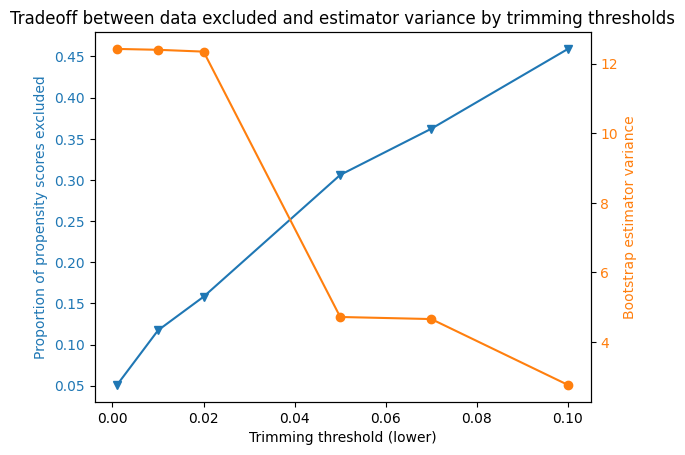

In [44]:
fig, ax1 = plt.subplots()
ax1.plot(test_thresholds, data_invalid_prop, label='Proportion of propensity scores excluded', marker='v', color='tab:blue')
ax1.set_ylabel('Proportion of propensity scores excluded', color = 'tab:blue')
ax1.tick_params(axis ='y', labelcolor = 'tab:blue')
ax2 = ax1.twinx()
ax2.plot(test_thresholds, ate_vars, label='Bootstrap estimator variance', marker='o', color='tab:orange')
ax2.set_ylabel('Bootstrap estimator variance', color = 'tab:orange')
ax2.tick_params(axis ='y', labelcolor = 'tab:orange')
ax1.set_xlabel('Trimming threshold (lower)')
plt.title('Tradeoff between data excluded and estimator variance by trimming thresholds')
plt.show()

In [45]:
ates = get_bootstrapped_ate(xyz, 0.05, 0.95, 1000)
confidence_interval = [np.percentile(ates, 2.5), 
                       np.percentile(ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0], decimals = 3)} to {np.round(confidence_interval[1], decimals = 3)}")
print("The variance of estimator is", statistics.variance(ates))

Our 95% confidence interval ranges from -3.393 to 5.117
The variance of estimator is 4.717778640322585


Text(0.5, 1.0, 'Bootstrapped Estimates of the ATE')

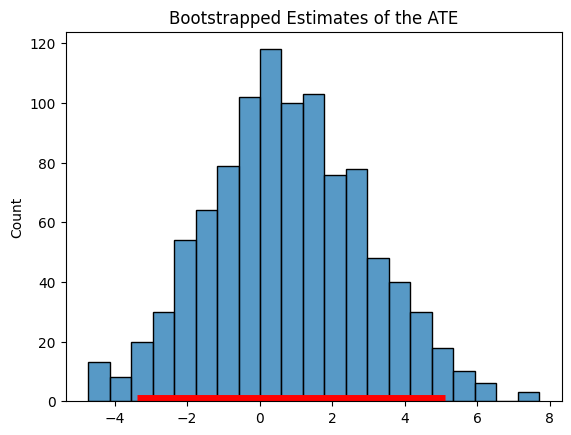

In [46]:
sns.histplot(ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5, color = "red")
plt.title("Bootstrapped Estimates of the ATE")